In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [3]:
data = tf.keras.utils.image_dataset_from_directory("./Lung Cancer Dataset/Lung cancer",seed=42)

Found 1076 files belonging to 3 classes.


In [4]:
# print("Class names:", data.class_names)
class_indices = {name: index for index, name in enumerate(data.class_names)}
print("Class indices:", class_indices)

Class indices: {'Bengin cases': 0, 'Malignant cases': 1, 'Normal cases': 2}


In [5]:
# data_iterator = data.as_numpy_iterator()
# batch = data_iterator.next()
# print(batch[0].shape)
# print(batch[1])

In [6]:
# fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# for idx, img in enumerate(batch[0][:4]):
#   ax[idx].imshow(img.astype(int))
#   ax[idx].title.set_text(batch[1][idx])

In [7]:
# preprocess Data

In [8]:
data = data.map(lambda x, y: (x/ 255, y))

In [9]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()
batch[0].max()

1.0

In [11]:
# fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# for idx, img in enumerate(batch[0][:4]):
#   ax[idx].imshow(img)
#   ax[idx].title.set_text(batch[1][idx])

In [12]:
batch_size = 32
train_size = int(len(data)* .7)
val_size = int(len(data)*.2) + 1
test_size =  int(len(data)* .1) + 1

print(len(data)*batch_size)
print(train_size * batch_size)
print(val_size * batch_size)
print(test_size * batch_size)
print((train_size * batch_size) + (val_size * batch_size) + (test_size * batch_size))

1088
736
224
128
1088


In [13]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [14]:
# model CNN

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [16]:
model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(256,256,3)), # filer size 3x3 stride here is default
    MaxPooling2D(2,2),

    Conv2D(32, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Conv2D(16, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Flatten(),
    # Dense(256, activation="relu",kernel_regularizer = tf.keras.regularizers.l2(0.1)), # If you want regularization
    Dense(256, activation="relu"),
    Dense(3, activation="linear")
])

In [17]:
model.compile(loss = SparseCategoricalCrossentropy(from_logits=True), optimizer = Adam() , metrics = ['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [19]:
logdir = "logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [20]:
hist = model.fit(train,epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10


23/23 [==============================] - 9s 354ms/step - loss: 0.9627 - accuracy: 0.5625 - val_loss: 0.7184 - val_accuracy: 0.7232
Epoch 2/10
23/23 [==============================] - 8s 320ms/step - loss: 0.5984 - accuracy: 0.7649 - val_loss: 0.3747 - val_accuracy: 0.8527
Epoch 3/10
23/23 [==============================] - 8s 316ms/step - loss: 0.2877 - accuracy: 0.9022 - val_loss: 0.1945 - val_accuracy: 0.9509
Epoch 4/10
23/23 [==============================] - 7s 302ms/step - loss: 0.1146 - accuracy: 0.9701 - val_loss: 0.1040 - val_accuracy: 0.9821
Epoch 5/10
23/23 [==============================] - 7s 303ms/step - loss: 0.0664 - accuracy: 0.9864 - val_loss: 0.0486 - val_accuracy: 0.9777
Epoch 6/10
23/23 [==============================] - 7s 299ms/step - loss: 0.0205 - accuracy: 0.9986 - val_loss: 0.0295 - val_accuracy: 0.9911
Epoch 7/10
23/23 [==============================] - 7s 303ms/step - loss: 0.0088 - accuracy: 0.9986 - val_loss: 0.0157 - val_accuracy: 0.9955
Epoc

In [21]:
# Accuracy Checking

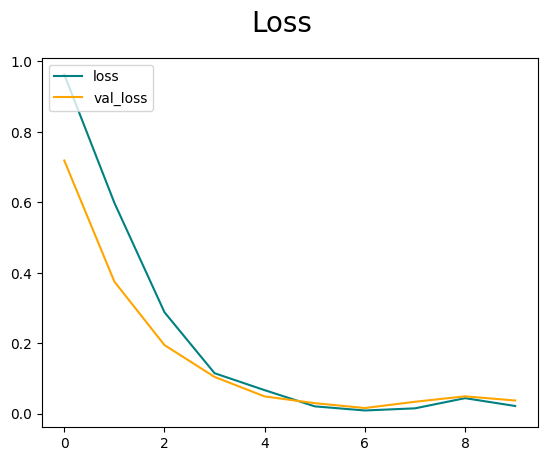

In [22]:
fig = plt.figure()
plt.plot(hist.history["loss"], color = "teal", label = "loss")
plt.plot(hist.history["val_loss"], color = "orange", label = "val_loss")
fig.suptitle("Loss", fontsize=20)
plt.legend(loc="upper left")
plt.show()

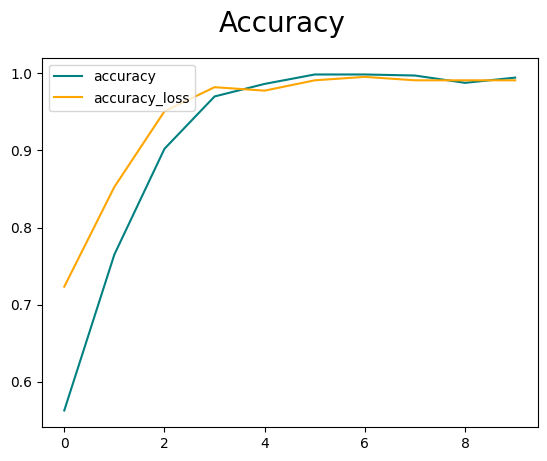

In [23]:
fig = plt.figure()
plt.plot(hist.history["accuracy"], color = "teal", label = "accuracy")
plt.plot(hist.history["val_accuracy"], color = "orange", label = "accuracy_loss")
fig.suptitle("Accuracy", fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [24]:
from tensorflow.keras.metrics import Precision, Recall, SparseCategoricalAccuracy

In [25]:
# Precision -> Out of all the patient where we predicted y = x how many actually had that disease (what fraction)
pre = Precision()
# recall -> All the patient that have the disease what fraction did we correctly detect as having it
re = Recall()
acc = SparseCategoricalAccuracy()

In [26]:
for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model.predict(X)
  predicted_classes = yhat.argmax(axis=1)
  pre.update_state(y,predicted_classes)
  re.update_state(y,predicted_classes)
  acc.update_state(y,yhat)

1/1 [==============================] - 0s 147ms/step


In [27]:
print(f"Precision : {pre.result()}")
print(f"Recall : {re.result()}")
print(f"Accuracy : {acc.result()}")

Precision : 0.9903846383094788
Recall : 1.0
Accuracy : 0.9913793206214905


In [28]:
# testing on unseen data

In [29]:
from tensorflow.keras.models import load_model
import cv2

In [32]:
model.save(os.path.join("cancer_predictor.h5"))

In [33]:
lung_cancer_model = load_model(os.path.join("cancer_predictor.h5"))

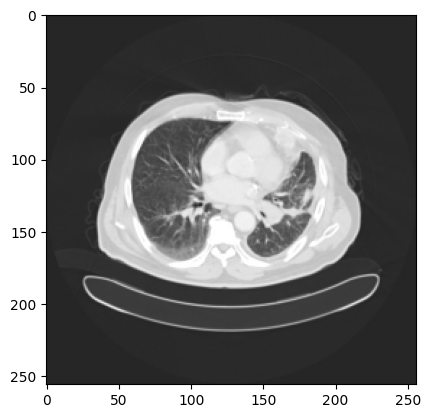

In [35]:
# imgTest = cv2.imread("./Lung Cancer Dataset/unseen dataset/Normal case (414).jpg")
imgTest = cv2.imread("./Lung Cancer Dataset/unseen dataset/Malignant case (558).jpg")
# imgTest = cv2.imread("./Lung Cancer Dataset/unseen dataset/Bengin case (89).jpg")
# imgTest = cv2.imread("./Lung Cancer Dataset/unseen dataset/lungGoogle.jpg")
resize = tf.image.resize(imgTest, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [36]:
model_prediction = lung_cancer_model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 66ms/step


In [37]:
predicted_class = model_prediction.argmax(axis=1)[0]
print(predicted_class)

if predicted_class == 0:
  print("Benign Case")
elif predicted_class == 1:
  print("malignant case")
else:
  print("Normal case")

1
malignant case
